## Using saas.csv or log data from API usage or store_item_sales

### Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [1]:
# imports
from prepare import stores_sales_items_complete
from prepare import prep_all_data
from prepare import sales_total_adder, evaluate, plot_and_eval
from statsmodels.tsa.api import Holt

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# importing all data 
df1 = stores_sales_items_complete()

# prepping data
df1 = prep_all_data(df1)

In [3]:
# creating copy of data so we have an unmodified copy we can access in case we need to "reset" our DF 
# this allows us to avoid having to run the prep function above multiple times since it takes several minutes
df = df1.copy()

# previewing data
df.head(2)

,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,day_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,January,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,January,218.40


In [4]:
# adding total sales column
df = sales_total_adder(df)

# previewing data
df.head(2)

,item,sale_amount,sale_id,store,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,day_week,month,sales_total
sale_date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tuesday,January,10.92
2013-01-01 00:00:00+00:00,12,26.0,211817,7,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,Tuesday,January,218.40


In [5]:
# resampling data as weekly sum
dfm = df.resample('W').sum()

# removing time portion of date column
dfm.index = dfm.index.date

# removing all columns besides index and sales_total
dfm = dfm[['sales_total']]

# previewing data
dfm.head()

,sales_total
2013-01-06,490767.50
2013-01-13,559934.21
2013-01-20,552813.52
2013-01-27,554908.84
2013-02-03,586547.55


In [6]:
# creating csv of DF in case we need to "Reset" it later, we can avoid needed to run the code above
dfm.to_csv('dfm.csv',index=True)

In [7]:
dfm = pd.read_csv('dfm.csv')

dfm.rename(columns={'Unnamed: 0':'date'}, inplace=True)

# set sale_date as index then sort df by index 
dfm = dfm.set_index('date').sort_index()

dfm.head()

,sales_total
date,
2013-01-06,490767.50
2013-01-13,559934.21
2013-01-20,552813.52
2013-01-27,554908.84
2013-02-03,586547.55


In [8]:
# splitting data

# setting % of original DFs rows that train will contain
train_size = .70

# getting count of original DFs rows
n = dfm.shape[0]

# calculating number of rows that train will contain
train_row_count = round(train_size * n)

# gathering # of rows from original df equal to train_row_count
train = dfm[:train_row_count] 

# gathering # of rows from original df minus train_row_count
test = dfm[train_row_count:] 

# checking train shape to see if columns and rows are correct after split
train.shape

(183, 1)

#### Make sure sum of row count from train and test is equal to row count of original df

In [9]:
print(len(train) + len(test) == len(dfm))

True


#### Make sure 1st row of train is same as 1st row of original df

In [10]:
print(dfm.head(1) == train.head(1))

            sales_total
date                   
2013-01-06         True


#### Make sure last row of test is same as last row of original df

In [11]:
print(dfm.tail(1) == test.tail(1))

            sales_total
date                   
2017-12-31         True


#### Is the last row of train 1 week behind the first row of  test?

In [12]:
pd.concat([train.tail(1), test.head(1)])

,sales_total
date,
2016-07-03,1323250.74
2016-07-10,1364502.30


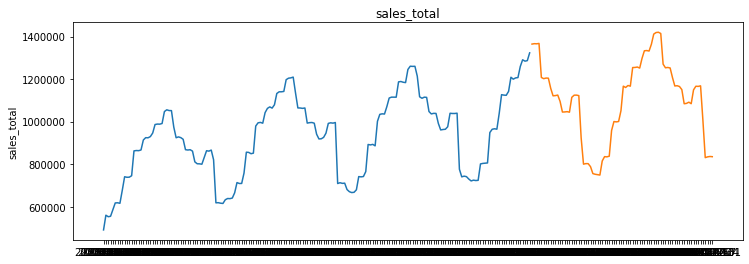

In [13]:
# plotting data to ensure our split was successful
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

We see a gap in the plot since each date accounts for the the week of data behind it. Test begins on 7/10, but covers data from 7/4 onward. Since 7/4 - 7/9 are not listed in either data set they are shown as a gap in the plot.

## Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [14]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store each models RMSE value so we can compare as we proceed
def append_eval_df(model_type, target_var, test, yhat_df):
    """
    Function stores RMSE in DF for later comparison.
    """
    # calculate RMSE
    rmse = evaluate(target_var, test, yhat_df)
    # append to data frame and return
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average

In [15]:
# calculating average of total sales
dollars = round(train['sales_total'].mean(),2)

dollars

930086.06

In [16]:
# function creates a new df with sales total always equal to mean
def make_predictions():
    yhat_df = pd.DataFrame({'sales_total': [dollars]}, index = test.index)
    return yhat_df

In [17]:
# creating df using function above
yhat_df = make_predictions()

# previewing DF
yhat_df.head()

,sales_total
date,
2016-07-10,930086.06
2016-07-17,930086.06
2016-07-24,930086.06
2016-07-31,930086.06
2016-08-07,930086.06


sales_total -- RMSE: 258093


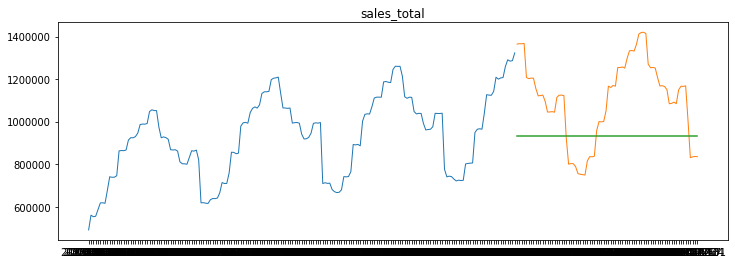

In [18]:
# calculating RMSE value and plotting data against actual values
plot_and_eval('sales_total', train, test, yhat_df)

In [19]:
# adding RMSE value to DF
eval_df = append_eval_df('simple_average', 'sales_total', test, yhat_df)

# previewing data
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,258093.0


### Moving Average

In [20]:
# setting period to 4 (weeks)
period = 4

# calculating average sales on 4 week rolling period
dollars = round(train['sales_total'].rolling(period).mean()[-1], 2)

print(dollars)

1296195.22


In [21]:
# storing predictions in DF
yhat_df = make_predictions()

# previewing data
yhat_df.head()

,sales_total
date,
2016-07-10,1296195.22
2016-07-17,1296195.22
2016-07-24,1296195.22
2016-07-31,1296195.22
2016-08-07,1296195.22


sales_total -- RMSE: 268260


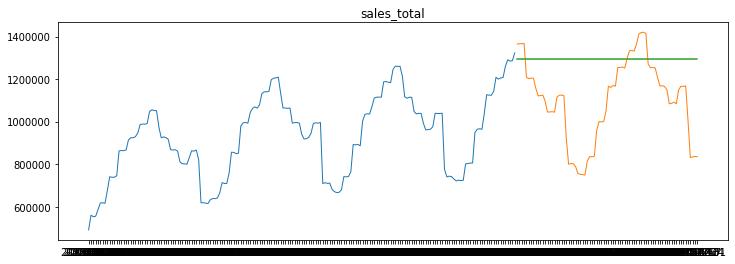

In [22]:
# calculating RMSE value and plotting predictions vs actual values
plot_and_eval('sales_total', train, test, yhat_df)

In [23]:
# adding moving average RMSE to DF
eval_df = append_eval_df('moving average', 'sales_total', test, yhat_df)

# previewing data
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,258093.0
1,moving average,sales_total,268260.0


### Holt's Linear Trend Model

In [24]:
# making predictions using Holt's linear trend model
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = test.index[0],
                               end = test.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [25]:
# # previewing data
yhat_df.head()

,sales_total
date,
2016-07-10,1331233.50
2016-07-17,1338177.20
2016-07-24,1344217.08
2016-07-31,1349470.79
2016-08-07,1354040.66


sales_total -- RMSE: 334560


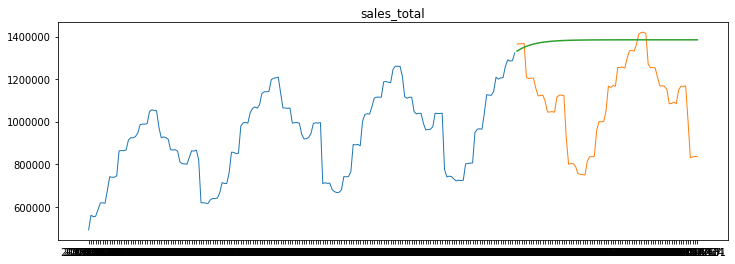

In [26]:
# plotting predictions vs actual values and calculating RMSE value
plot_and_eval('sales_total', train, test, yhat_df)

In [27]:
# adding RMSE value from Holts model to DF
eval_df = append_eval_df('holts_optimized', 'sales_total', test, yhat_df)

# previewing data
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,258093.0
1,moving average,sales_total,268260.0
2,holts_optimized,sales_total,334560.0


### Predict based on previous cycle

In [28]:
# resetting datetime type of dfm
# had to convert to "date type" early on because time kept appearing in column
# swapping back now and it doesn't reappear. Very peculiar. Will need to test this more later to see what happened.
# For now I'm reverting to datetime so the code below will work
dfm.index = pd.to_datetime(dfm.index)

In [29]:
# resplitting data

# train equals all data from 2015 and prior
train = dfm[:'2015']

# test equals all 2016 data
test = dfm['2016']

# checking row counts as sanity check for split
# test should equal 52, train should equal 156 (52 * 3) since there are 52 weeks in year
print(train.shape)
print(test.shape)

(156, 1)
(52, 1)


In [30]:
# finding the year-over-year difference for each week from 2013 to 2015
# taking the mean, and then adding that value to the weekly 2015 values. 
yhat_df = train['2015'] + train.diff(52).mean()

# set yhat_df to index of validate
yhat_df.index = test.index

sales_total -- RMSE: 22730


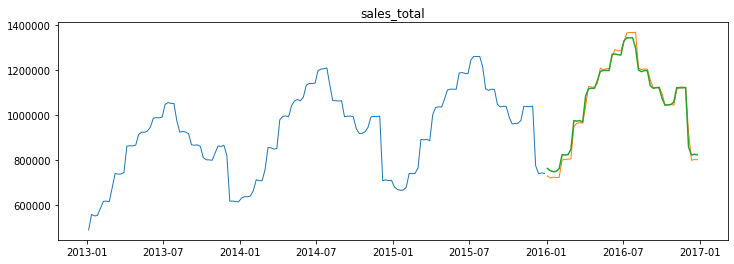

In [31]:
# plot predictions and calculate RMSE
plot_and_eval('sales_total', train, test, yhat_df)

In [32]:
# adding RMSE to DF
eval_df = append_eval_df('previous_cycle', 'sales_total', test, yhat_df)

# inspecting final RMSE values
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,258093.0
1,moving average,sales_total,268260.0
2,holts_optimized,sales_total,334560.0
3,previous_cycle,sales_total,22730.0


## Conclusion

- Previous cycle was by far the best model
    - This makes sense given that our data follows a very patterned flow from year to year
- Our worst model was the holts optimized
- Simple average and moving average performed relatively close to one another with simple_average winning by a small margin